# CNN using Tensorflow Keras on MRI Image Data - failed attempt (memory out)

## Data Use Agreements
The data used for this project were provided in part by OASIS and ADNI.

OASIS-3: Principal Investigators: T. Benzinger, D. Marcus, J. Morris; NIH P50 AG00561, P30 NS09857781, P01 AG026276, P01 AG003991, R01 AG043434, UL1 TR000448, R01 EB009352. AV-45 doses were provided by Avid Radiopharmaceuticals, a wholly owned subsidiary of Eli Lilly.

Data collection for this project was done through the Alzheimer's Disease Neuroimaging Initiative (ADNI) (National Institutes of Health Grant U01 AG024904) and DOD ADNI (Department of Defense award number W81XWH-12-2-0012). ADNI is funded by the National Institute on Aging, the National Institute of Biomedical Imaging and Bioengineering, and through generous contributions from the following: AbbVie, Alzheimer’s Association; Alzheimer’s Drug Discovery Foundation; Araclon Biotech; BioClinica, Inc.; Biogen; Bristol-Myers Squibb Company; CereSpir, Inc.; Cogstate; Eisai Inc.; Elan Pharmaceuticals, Inc.; Eli Lilly and Company; EuroImmun; F. Hoffmann-La Roche Ltd and its affiliated company Genentech, Inc.; Fujirebio; GE Healthcare; IXICO Ltd.; Janssen Alzheimer Immunotherapy Research & Development, LLC.; Johnson & Johnson Pharmaceutical Research & Development LLC.; Lumosity; Lundbeck; Merck & Co., Inc.; Meso Scale Diagnostics, LLC.; NeuroRx Research; Neurotrack Technologies; Novartis Pharmaceuticals Corporation; Pfizer Inc.; Piramal Imaging; Servier; Takeda Pharmaceutical Company; and Transition Therapeutics. The Canadian Institutes of Health Research is providing funds to support ADNI clinical sites in Canada. Private sector contributions are facilitated by the Foundation for the National Institutes of Health (www.fnih.org). The grantee organization is the Northern California Institute for Research and Education, and the study is coordinated by the Alzheimer’s Therapeutic Research Institute at the University of Southern California. ADNI data are disseminated by the Laboratory for Neuro Imaging at the University of Southern California.

## Setup

### General Imports

In [1]:
import nibabel.freesurfer.mghformat as mgh

from tqdm.notebook import tqdm

import os, sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

### Set up and test Tensorflow

In [2]:
import tensorflow as tf

In [3]:
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensor Flow Version: 2.2.0
Keras Version: 2.3.0-tf

Python 3.8.10 (default, Jun  4 2021, 15:09:15) 
[GCC 7.5.0]
Pandas 1.2.4
Num GPUs Available:  1


In [4]:
tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


## Load data

### CSV

In [5]:
rootdir = '/home/jack/Code/GitHub/Polygence/'
df = pd.read_csv(rootdir + 'Data/OASIS/csv_files/oasis_3.csv')
df.head()

,Subject,MR ID,id,Age,M/F,dx1,mmse,cdr,apoe,TOTAL_HIPPOCAMPUS_VOLUME,...,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
0,OAS30001,OAS30001_MR_d3132,OAS30001_Freesurfer53_d3132,73.0,F,Cognitively normal,30.0,0.0,23.0,6861.9,...,178031.558882,359975.257636,48400.0,491102.257636,7.736716e+05,174372.329393,173244.012238,347616.341631,67598.1,67185.8
1,OAS30001,OAS30001_MR_d0129,OAS30001_Freesurfer53_d0129,65.0,F,Cognitively normal,30.0,0.0,23.0,7678.9,...,187528.786036,379446.180091,50687.0,517683.180091,8.105851e+05,184600.488060,182662.445419,367262.933479,70168.1,69483.8
2,OAS30001,OAS30001_MR_d2430,OAS30001_Freesurfer53_d2430,71.0,F,Cognitively normal,30.0,0.0,23.0,7105.9,...,178872.680224,357784.489639,49058.0,487405.489639,7.779313e+05,175955.968883,178172.812666,354128.781549,67905.7,68000.2
3,OAS30001,OAS30001_MR_d0757,OAS30001_Freesurfer53_d0757,67.0,F,Cognitively normal,29.0,0.0,23.0,7648.2,...,177566.874682,362040.150904,50071.0,500699.150904,7.993419e+05,185224.779932,188151.990316,373376.770247,69142.3,68558.8
4,OAS30002,OAS30002_MR_d2345,OAS30002_Freesurfer53_d2345,73.0,M,Cognitively normal,29.0,0.0,34.0,7833.2,...,230240.532783,457342.035802,56773.0,607473.035802,1.051714e+06,239168.338419,245361.377267,484529.715686,83138.1,85742.3


In [6]:
df = df.dropna(axis=1, how='all') # Drop any empty columns
df = df.dropna(axis=0, how='any') # Drop any rows with empty values 
df = df.rename(columns={'id':'FS ID', 'dx1':'Diagnosis'}) # Rename columns
df = df.drop_duplicates(subset='Subject', keep='first') # Keep only the first visit
df = df.reset_index(drop=True) # Reset the index
df.loc[df['cdr'] < 0.5, 'Diagnosis'] = 'control'
df.loc[~(df['cdr'] < 0.5), 'Diagnosis'] = 'dementia'
# df['Diagnosis'].replace(['control','dementia'], [-1,1], inplace=True)
df = df.drop(df.columns.difference(['Subject', 'MR ID', 'FS ID', 'Diagnosis']), axis=1) # Drop all columns unless needed
print(df.shape)

(1022, 4)


In [7]:
df.head()

,Subject,MR ID,FS ID,Diagnosis
0,OAS30001,OAS30001_MR_d3132,OAS30001_Freesurfer53_d3132,control
1,OAS30002,OAS30002_MR_d2345,OAS30002_Freesurfer53_d2345,control
2,OAS30003,OAS30003_MR_d2682,OAS30003_Freesurfer53_d2682,control
3,OAS30004,OAS30004_MR_d2232,OAS30004_Freesurfer53_d2232,control
4,OAS30005,OAS30005_MR_d2377,OAS30005_Freesurfer53_d2377,control


<AxesSubplot:xlabel='Diagnosis', ylabel='count'>

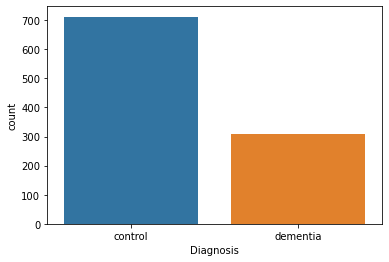

In [8]:
sns.countplot(x='Diagnosis', data=df)

### MRI
Since all the files are already transformed via the freesurfer, I don't think we'll need to do any major preprocessing like cropping, flipping, or rotating.
```
main_directory/
    control/
        mr_id_001/
            brain_image.mgz
            brain_image_transformed.mgz
            talairach.xfm
        mr_id_002/
            brain_image.mgz
            brain_image_transformed.mgz
            talairach.xfm
    dementia/
        mr_id_003/
            brain_image.mgz
            brain_image_transformed.mgz
            talairach.xfm
        mr_id_004/
            brain_image.mgz
            brain_image_transformed.mgz
            talairach.xfm
```

In [9]:
def read_mri_scan(path):
    """Read and load an MRI volume from file path"""
    volume = mgh.load(path).get_fdata().astype("float32")

    # In case the bash script missed a transform on a scan
    if volume.shape != (256, 256, 256):
        raise Exception(f"Image shape is not standard. You need to do resizing on {path}.")

    return volume

def normalize(volume):
    """ Normalize the MRI volume """
    min = 0.0
    max = 255.0
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def process_mri_scan(path):
    """ Read in and process the MRI scan, if necessary """
    # Read the scan
    volume = read_mri_scan(path)
    # print(volume.max(), volume.min(), volume.dtype)
    volume = normalize(volume)
    # print(volume.max(), volume.min(), volume.dtype)
    return volume

#### Example

In [10]:
example_path = '/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30001_MR_d3132/OAS30001_Freesurfer53_d3132_brain_transformed.mgz'
volume = process_mri_scan(example_path)
print(volume.max(), volume.min(), volume.dtype, volume.shape)

0.7563453 0.0 float32 (256, 256, 256)


In [11]:
data_dir = os.path.join(rootdir, 'Data/OASIS/mri_data/')

control_scan_paths = []
dementia_scan_paths = []

labels = os.listdir(data_dir)
for label in labels:
    label_dir = os.path.join(data_dir, label)
    ids = os.listdir(label_dir)
    for id in tqdm(ids, desc=label):
        mr_dir = os.path.join(label_dir, id)
        img_file = [file for file in os.listdir(mr_dir) if "transformed" in file]
        img_path = os.path.join(mr_dir, img_file[0])
        if label == 'control':
            control_scan_paths.append(img_path)
        else:
            dementia_scan_paths.append(img_path)

dementia:   0%|          | 0/310 [00:00<?, ?it/s]

control:   0%|          | 0/712 [00:00<?, ?it/s]

In [12]:
print(len(control_scan_paths), len(dementia_scan_paths))

712 310


In [14]:
print(control_scan_paths[0])
print(dementia_scan_paths[0])

/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/control/OAS30050_MR_d1530/OAS30050_Freesurfer53_d1530_brain_transformed.mgz
/home/jack/Code/GitHub/Polygence/Data/OASIS/mri_data/dementia/OAS30043_MR_d0145/OAS30043_Freesurfer53_d0145_brain_transformed.mgz


## Create the train and validation datasets

In [ ]:
# Read in the control scans
control_scans = np.array([process_mri_scan(path) for path in tqdm(control_scan_paths)])

  0%|          | 0/712 [00:00<?, ?it/s]

In [ ]:
# Read in the dementia scans
dementia_scans = np.array([process_mri_scan(path) for path in tqdm(dementia_scan_paths)])

In [ ]:
# Shuffle the data
np.random.shuffle(control_scans)
np.random.shuffle(dementia_scans)

In [ ]:
# Create the label arrays
# assign 1 for dementia patients, and 0 for control
control_labels = np.full(shape=len(control_scans), fill_value=0)
dementia_labels = np.full(shape=len(dementia_scans), fill_value=1)